In [ ]:
import numpy as np
import pandas as pd
import db_operations as dbop
from data_prepare import prepare_data,gen_y, drop_null, feature_select,label

import xgboost.sklearn as xgb
import lightgbm.sklearn as lgbm
import sklearn.metrics as metrics
import time
import sklearn.preprocessing as preproc

import matplotlib.pyplot as plt


def gen_data(pred_period=20,
             lower_bound="2011-01-01",
             start="2014-01-01"):
    db_type = "sqlite3"
    conn = dbop.connect_db(db_type)
    cursor = conn.cursor()

    df_all, cols_future = prepare_data(cursor, pred_period=pred_period,
                                       start=lower_bound)

    data_period = (df_all.index >= start)
    df_all = df_all[data_period]

    df_all = df_all[df_all["amt"] != 0]
    return df_all, cols_future


def gen_X(df_all:pd.DataFrame,cols_future, scaler=None, selector=None):
    features = df_all.columns.difference(cols_future + ["code"])
    X = df_all[features]
    if scaler:
        X = X.transform(X)
    if selector:
        X = X.transform(X)
    return X


def gen_dataset(pred_period=20,
             lower_bound="2011-01-01",
             start="2014-01-01", 
             test_start="2018-01-01",
             label_type=None,
             is_drop_null=False, 
             is_normalized=False,
             is_feature_selected=False):
    """
    Generate training and testing data to be passed to train().
    :param pred_period:
    :param is_drop_null:
    :param is_normalized:
    :param is_feature_selected:
    :return:
    """
    df_all,cols_future = gen_data(pred_period,lower_bound,start)

    y = gen_y(df_all, threshold=0.15, pred_period=pred_period,label_type=label_type)
    print("null:", sum(y.isnull()))

    features = df_all.columns.difference(cols_future + ["code"])

    X_full = df_all[y.notnull()]
    X = X_full[features]
    y = y.dropna()
    if is_drop_null:
        X, y = drop_null(X, y)

    print("X_full,X,y:", X_full.shape, X.shape, y.shape)
    print("total positive", sum(y))

    test_period = (X.index >= test_start)
    X_train, y_train = X[~test_period], y[~test_period]
    X_test, y_test = X[test_period], y[test_period]
    print(X_test.shape, y_test.shape)
    print("test positive:", sum(y_test))

    X_train_full = X_full[~test_period]
    X_test_full = X_full[test_period]
    print(X_test_full.shape, X_test.shape)

    scaler = None
    if is_normalized:
        scaler = preproc.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    selector=None
    if is_feature_selected:
        X_train, selector = feature_select(X_train, y_train)
        X_test = selector.transform(X_test)

    return (X_train, y_train), (X_test, y_test), (X_train_full, 
                                                  X_test_full),(scaler,selector)


                 code      open      high       low     close        vol  \
date                                                                       
2018-01-02  002217.SZ  56.11754  56.45492  55.55524  56.00508  191532.71   

                   amt  adj_factor  
date                                
2018-01-02  190581.978       5.623  
                 code      open      high       low     close        vol  \
2018-01-02  002217.SZ  56.11754  56.45492  55.55524  56.00508  191532.71   

                   amt  adj_factor  change_rate_p1mv_open  \
2018-01-02  190581.978       5.623               0.007014   

            change_rate_p1mv_high        ...          \
2018-01-02                0.00996        ...           

            change_rate_p250mean_amt  f1mv_open  f1mv_high  f1mv_low  \
2018-01-02                  0.063479   55.83639   58.14182  55.78016   

            f1mv_close  f19max_f2mv_high  f20min_f1mv_low  f6mean_f2mv_open  \
2018-01-02    57.80444          58.31051       

['000001.SZ'] (2370, 132)
['000001.SZ'] (182, 132)
['000002.SZ'] (2370, 132)
['000002.SZ'] (182, 132)
['000063.SZ'] (2370, 132)
['000063.SZ'] (182, 132)
['000070.SZ'] (2370, 132)
['000070.SZ'] (182, 132)
['000333.SZ'] (1227, 132)
['000333.SZ'] (182, 132)
['000636.SZ'] (2370, 132)
['000636.SZ'] (182, 132)
['000651.SZ'] (2370, 132)
['000651.SZ'] (182, 132)
['000725.SZ'] (2370, 132)
['000725.SZ'] (182, 132)
['000858.SZ'] (2370, 132)
['000858.SZ'] (182, 132)
['002027.SZ'] (2370, 132)
['002027.SZ'] (182, 132)
['002217.SZ'] (2370, 132)
['002217.SZ'] (182, 132)
['002236.SZ'] (2370, 132)
['002236.SZ'] (182, 132)
['002335.SZ'] (2119, 132)
['002335.SZ'] (182, 132)
['002359.SZ'] (2099, 132)
['002359.SZ'] (182, 132)
['002402.SZ'] (2042, 132)
['002402.SZ'] (182, 132)
['002415.SZ'] (2029, 132)
['002415.SZ'] (182, 132)
['002446.SZ'] (2000, 132)
['002446.SZ'] (182, 132)
['002913.SZ'] (203, 132)
['002913.SZ'] (182, 132)
['300038.SZ'] (2122, 132)
['300038.SZ'] (182, 132)
['300059.SZ'] (2077, 132)
['3000

(2126, 395) 2126


(76597, 527)


before 2376
y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 0
-0.20<=y<-0.10: 27
-0.10<=y<0.00: 2349
0.00<=y<0.10: 19043
0.10<=y<0.20: 9880
0.20<=y<0.30: 3506
0.30<=y<0.40: 1373
0.40<=y<0.50: 545
y>0.5 637
after 2376
--------------
2018-09-04   NaN
2018-09-05   NaN
2018-09-06   NaN
2018-09-07   NaN
2018-09-07   NaN
2018-09-07   NaN
2018-09-10   NaN
2018-09-11   NaN
dtype: float64
过滤涨停项： 244
null: 734


X_full,X,y: (37361, 527) (37361, 517) (37361,)
total positive 4200.323652274143
(5795, 517) (5795,)
test positive: 476.40301496894057


(5795, 527) (5795, 517)


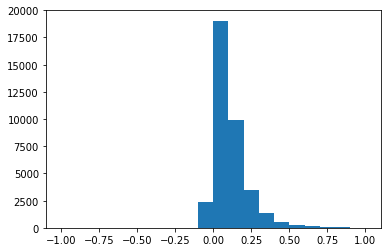

In [15]:
data = gen_dataset(label_type=None)

In [16]:
(X_train, y_train), (X_test, y_test), (X_train_full, X_test_full),_ = data
print(X_test_full[X_test_full["f19max_f2mv_high"].isna()].loc[:,["code",
                                                                 "open",
                                                                 "close",
                                                                 "f19max_f2mv_high"]])
print(y_test[y_test.isna()])

Empty DataFrame
Columns: [code, open, close, f19max_f2mv_high]
Index: []
Series([], dtype: float64)


In [19]:
def train(data, models, is_reg=True):
    (X_train, y_train), (X_test, y_test),_,_ = data
    if not is_reg:
        scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    y_pred_list = []
    colors = ["r", "b"]

    for model, c in zip(models, colors):
        t1 = time.time()
        model.fit(X_train, y_train)
        t2 = time.time()
        if is_reg:
            y_pred_list.append([model, t2 - t1, model.predict(X_test), c])
        else:
            y_pred_list.append([model, t2 - t1, model.predict_proba(X_test), c])

    return y_pred_list


In [20]:
regs = [
    lgbm.LGBMRegressor(n_estimators=300, num_leaves=100, max_depth=8,
                       random_state=0),
    xgb.XGBRegressor(n_estimators=300, max_depth=5, random_state=0)
]
# _,(_,y_test),_ = data
# plt.hist(y_test,bins=np.arange(-10,11)*0.1)
y_pred_list_reg = train(data,regs,is_reg=True)

In [15]:
clfs = [lgbm.LGBMClassifier(n_estimators=300, scale_pos_weight=0.1,
                            num_leaves=100, max_depth=8,
                            random_state=0),
        xgb.XGBClassifier(n_estimators=300, scale_pos_weight=0.1,
                          max_depth=5, random_state=0, )
        ]
(X_train, y_train), (X_test, y_test), (X_train_full, X_test_full) = data
y_train = label(y_train,0.15,label_type="inc")
y_test = label(y_test,0.15,label_type="inc")
data = (X_train, y_train), (X_test, y_test), (X_train_full, X_test_full)
y_pred_list_clf = train(data,clfs,is_reg=False)

In [16]:
_,_, (_, X_test_full) = data
inc = X_test_full[["code","f1mv_open",
                   "f19max_f2mv_high"]].copy()
inc["pct"] = inc["f19max_f2mv_high"]/inc["f1mv_open"]-1
y0 = inc["pct"].mean()
print(y0)
x0 = np.arange(11)*0.1
y0 = np.ones(x0.shape)*y0

0.08248621903957754


In [17]:
y_pred_clf = y_pred_list_clf[1][2][:,1]
threshold = 0.8
clf_pred_inc = X_test_full[y_pred_clf>threshold][["code","f1mv_open",
                                       "f19max_f2mv_high"]]
clf_pred_inc["pct"] = clf_pred_inc["f19max_f2mv_high"]/clf_pred_inc["f1mv_open"]-1
clf_pred_inc["y_pred"]=y_pred_clf[y_pred_clf>threshold]
for code, group in clf_pred_inc.groupby("code"):
    print(group)

                 code  f1mv_open  f19max_f2mv_high       pct    y_pred
2018-06-25  000063.SZ  203.65230         277.21972  0.361240  0.951405
2018-06-26  000063.SZ  206.96757         277.21972  0.339436  0.950841
2018-06-27  000063.SZ  202.07360         277.21972  0.371875  0.967484
2018-06-28  000063.SZ  206.33609         277.21972  0.343535  0.967498
2018-06-29  000063.SZ  205.70461         277.21972  0.347659  0.968806
2018-07-02  000063.SZ  191.81205         277.21972  0.445267  0.957633
2018-07-03  000063.SZ  212.33515         277.21972  0.305576  0.945221
2018-07-04  000063.SZ  213.12450         277.21972  0.300741  0.981344
2018-07-05  000063.SZ  207.75692         277.21972  0.334347  0.990305
2018-07-06  000063.SZ  207.59905         277.21972  0.335361  0.982108
2018-07-09  000063.SZ  205.54674         277.21972  0.348694  0.983463
2018-07-10  000063.SZ  193.23288         277.21972  0.434641  0.972529
2018-07-11  000063.SZ  210.12497         277.21972  0.319309  0.956016
2018-0

4641 0.0785086220949643
560 0.08800376241865039
210 0.0931380575818061
119 0.10089156164892521
92 0.10834246785983025
58 0.09692934134967832
41 0.06314148653385965
43 0.11621104490610476
16 0.18191581349232494
23 0.32487623359709983
15.379881319573


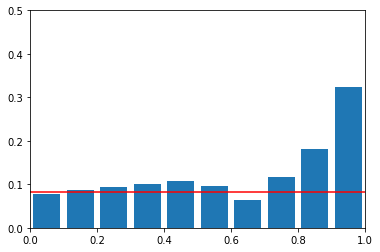

In [34]:
y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0<y_pred_clf) & (y_pred_clf<p1)
    cnt1.append(sum(cond))
    y1.append(inc["pct"][cond].mean())
for c,p in zip(cnt1,y1):
    print(c,p)
print(sum([c*p for i,(c,p) in enumerate(zip(cnt1,y1)) if i >6]))

plt.bar(np.arange(len(y1))*0.1+0.05,y1,width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

In [39]:
y_pred_reg = y_pred_list_reg[1][2]
threshold = 0.3
reg_pred_inc = X_test_full[y_pred_reg>threshold][["code","f1mv_open",
                                       "f19max_f2mv_high"]]
reg_pred_inc["pct"] = reg_pred_inc["f19max_f2mv_high"]/reg_pred_inc["f1mv_open"]-1
reg_pred_inc["y_pred"]=y_pred_reg[y_pred_reg>threshold]
for code, group in reg_pred_inc.groupby("code"):
    print(group)

                 code  f1mv_open  f19max_f2mv_high       pct    y_pred
2018-03-13  000002.SZ   4454.012          4732.731  0.062577  0.304577
2018-03-15  000002.SZ   4473.234          4732.731  0.058011  0.304083
2018-03-16  000002.SZ   4471.861          4732.731  0.058336  0.305664
2018-03-19  000002.SZ   4311.220          4732.731  0.097771  0.302383
2018-03-20  000002.SZ   4320.831          4732.731  0.095329  0.317230
2018-03-21  000002.SZ   4366.140          4732.731  0.083962  0.320625
2018-03-22  000002.SZ   4121.746          4732.731  0.148235  0.312895
2018-04-26  000002.SZ   3935.018          3962.478  0.006978  0.332661
2018-04-27  000002.SZ   3899.320          3962.478  0.016197  0.308034
2018-05-25  000002.SZ   3623.347          3913.050  0.079955  0.304426
                 code  f1mv_open  f19max_f2mv_high       pct    y_pred
2018-06-21  000063.SZ  236.48926         277.21972  0.172230  0.358224
2018-06-22  000063.SZ  212.80876         277.21972  0.302671  0.357050
2018-0

2172 0.07820798360655978
3023 0.08227272489728145
524 0.08479389526489958
64 0.1670283513920771
14 0.2163587067826629
5 0.351030299425437
1 0.3612403100775192
0 nan
0 nan
0 nan
15.83522819125492


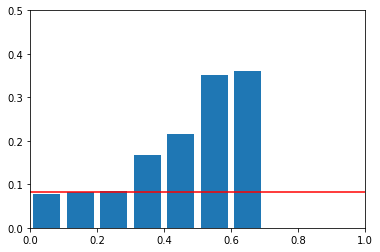

In [38]:
y2 = []
cnt2  = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0<y_pred_reg) & (y_pred_reg<p1)
    cnt2.append(sum(cond))
    y2.append(inc["pct"][cond].mean())
for c,p in zip(cnt2,y2):
    print(c,p)
print(sum([c*p for i,(c,p) in enumerate(zip(cnt2,y2)) if i >2 and not np.isnan(p)]))

plt.bar(np.arange(len(y2))*0.1+0.05,y2,width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y2,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.172e+03, 3.023e+03,
        5.240e+02, 6.400e+01, 1.400e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

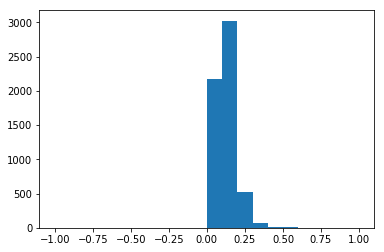

In [24]:
plt.hist(y_pred_reg,bins=np.arange(-10,11)*0.1)

In [1]:
print(X_test_full[X_test_full["f19max_f2mv_high"].isna()])

NameError: name 'X_test_full' is not defined

In [41]:
# save model
import pickle
import re
import os
for model in regs:
    fname = re.search("\.([^.]*)'",str(type(model))).group(1)
    print(fname)
    with open(os.path.join(r"C:\Users\dell-pc\Quant\Quant",fname),\
            "wb") as f:
        pickle.dump(model,f)

LGBMRegressor


XGBRegressor
